<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/flow_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# original paper
# https://arxiv.org/abs/1605.08803

# discussion
# https://spaces.ac.cn/archives/5807

# implementation from
# https://gemini.google.com/app/64f9247342835580

# my experiments
# https://colab.research.google.com/drive/1zHZgSFbQ4driCZkEUv5kt1Q-sogo1OCs#scrollTo=r1wTrQH64SfM

Using device: cuda
Created data directory: ./data


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.68MB/s]


Starting training...
Epoch 1/6, Loss: -5094.0663
Epoch 2/6, Loss: -5829.4981
Epoch 3/6, Loss: -5970.5566
Epoch 4/6, Loss: -6069.7316
Epoch 5/6, Loss: -6148.1229
Epoch 6/6, Loss: -6216.7024
Training finished.
Generating 64 samples...


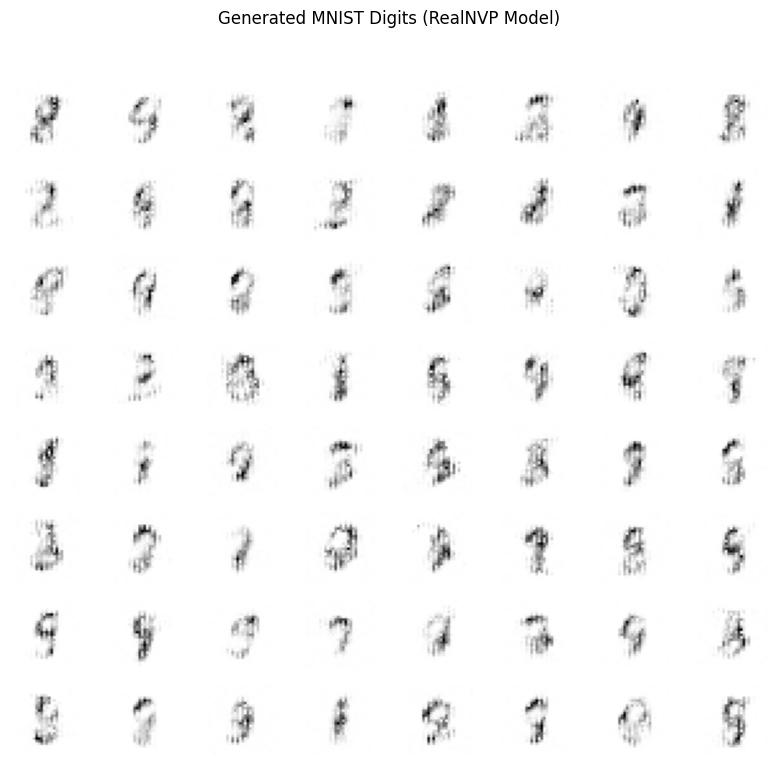

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os # For checking if data directory exists

# --- 1. Data Loading and Preprocessing ---
def load_mnist_data(batch_size=128):
    """
    Loads and preprocesses the MNIST dataset.

    Args:
        batch_size (int): The batch size for the DataLoader.

    Returns:
        tuple: A tuple containing (train_loader, test_loader).
    """
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts PIL Image to PyTorch Tensor and scales to [0, 1]
        # Flatten the 28x28 image to a 784-dimensional vector
        transforms.Lambda(lambda x: x.view(-1)),
        # Add a small amount of uniform noise for dequantization.
        # This is crucial for discrete data (like pixel values) when using
        # continuous normalizing flows. It effectively spreads the discrete
        # pixel values over a continuous interval [0, 1/256) for each pixel.
        transforms.Lambda(lambda x: x + torch.rand_like(x) / 256.0),
    ])

    # Ensure the data directory exists to store the downloaded MNIST dataset
    data_dir = './data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created data directory: {data_dir}")

    # Load MNIST training and testing datasets
    train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    # Create DataLoaders for efficient batching and shuffling
    # num_workers > 0 can speed up data loading, especially on GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2 if torch.cuda.is_available() else 0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2 if torch.cuda.is_available() else 0)
    return train_loader, test_loader

# --- 2. Define the Neural Network for the 's' (scale) and 't' (translation) functions ---
class ScaleAndTranslateNet(nn.Module):
    """
    A simple multi-layer perceptron (MLP) used within the Affine Coupling Layer.
    This network now outputs both scaling (s) and translation (t) factors.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initializes the ScaleAndTranslateNet.

        Args:
            input_dim (int): Dimension of the input to this network (size of x1).
            hidden_dim (int): Number of units in the hidden layers.
            output_dim (int): Dimension of the output from this network (2 * size of x2, for s and t).
        """
        super(ScaleAndTranslateNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(), # Activation function
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), # Activation function
            nn.Linear(hidden_dim, output_dim) # Output dimension is 2 * (size of x2)
        )

    def forward(self, x):
        """
        Forward pass for the ScaleAndTranslateNet.

        Args:
            x (torch.Tensor): Input tensor (corresponding to x1 in the coupling layer).

        Returns:
            torch.Tensor: Output tensor (concatenated s and t values).
        """
        return self.net(x)

# --- 3. Define the Affine Coupling Layer (RealNVP's core) ---
class AffineCouplingLayer(nn.Module):
    """
    An affine coupling layer, a core component of the RealNVP model.
    It splits the input into two parts, transforms one part affinely based on the other,
    and leaves the other part unchanged. This ensures invertibility and a tractable
    Jacobian determinant.
    """
    def __init__(self, input_dim, hidden_dim, mask_config):
        """
        Initializes an Affine Coupling Layer.

        Args:
            input_dim (int): The total dimension of the input data.
            hidden_dim (int): Hidden dimension for the internal ScaleAndTranslateNet.
            mask_config (int): Determines how the input is split (0 for even indices as x1, 1 for odd).
        """
        super(AffineCouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.mask_config = mask_config

        # Create a boolean mask to split the input for the current layer.
        # If mask_config is 0, even-indexed dimensions are x1 (unmodified part),
        # and odd-indexed dimensions are x2 (modified part).
        # If mask_config is 1, odd-indexed dimensions are x1, and even-indexed are x2.
        indices = torch.arange(input_dim)
        if mask_config == 0:
            self.mask = (indices % 2 == 0).float() # 1s for x1, 0s for x2
        else:
            self.mask = (indices % 2 != 0).float() # 1s for x1, 0s for x2

        # Determine the dimensions for x1 (input to ScaleAndTranslateNet) and x2 (output from ScaleAndTranslateNet).
        x1_dim = int(self.mask.sum().item())
        x2_dim = int((1 - self.mask).sum().item())

        # Initialize the internal neural network (s and t functions)
        # It needs to output 2 * x2_dim (one for scale, one for translate)
        self.scale_translate_net = ScaleAndTranslateNet(x1_dim, hidden_dim, 2 * x2_dim)

    def forward(self, x, log_det_jacobian):
        """
        Forward pass of the affine coupling layer: y = f(x).

        Args:
            x (torch.Tensor): Input tensor.
            log_det_jacobian (torch.Tensor): Accumulated log-determinant of the Jacobian from previous layers.

        Returns:
            tuple: (output_tensor_y, updated_log_det_jacobian).
        """
        mask = self.mask.to(x.device)
        # Split x into x1 (unmodified part) and x2 (part to be transformed)
        x1_unmasked = x * mask # Contains x1 values and zeros for x2 positions
        x2_unmasked = x * (1 - mask) # Contains x2 values and zeros for x1 positions

        # Extract the active values for x1 to feed into the scale_translate_net.
        x1_active = x1_unmasked[:, mask.bool()]

        # Compute the output of the scale_translate_net, which contains both s and t
        st_output = self.scale_translate_net(x1_active)

        # Split the output into scale (s) and translation (t) components
        s, t = st_output.chunk(2, dim=1) # Splits along dimension 1 into two equal chunks

        # Clamp s to prevent numerical instability with exp(s) (too large/small values)
        s = torch.clamp(s, -5., 5.) # Common practice to stabilize training

        # Apply the affine transformation: y2 = x2 * exp(s) + t
        # We create a zero tensor with the same shape as x2_unmasked and fill
        # the active (non-masked) positions with the transformed values.
        y2_unmasked = torch.zeros_like(x2_unmasked)
        y2_unmasked[:, (1 - mask).bool()] = x2_unmasked[:, (1 - mask).bool()] * torch.exp(s) + t
        # following works well, too
        # y2_unmasked[:, (1 - mask).bool()] = x2_unmasked[:, (1 - mask).bool()] * s + t

        # Combine y1 (which is just x1) and y2 to form the output y
        y = x1_unmasked + y2_unmasked

        # Add the log-determinant contribution from this affine coupling layer.
        # For an affine transformation y_i = x_i * exp(s_i) + t_i, the Jacobian determinant
        # is the product of exp(s_i) for the transformed dimensions.
        # The log-determinant is therefore sum(s_i) over the transformed dimensions.
        log_det_jacobian += s.sum(dim=1)

        return y, log_det_jacobian

    def inverse(self, y, log_det_jacobian):
        """
        Inverse pass of the affine coupling layer: x = f_inverse(y).

        Args:
            y (torch.Tensor): Input tensor (output from forward pass).
            log_det_jacobian (torch.Tensor): Accumulated log-determinant (not updated here).

        Returns:
            tuple: (output_tensor_x, unchanged_log_det_jacobian).
        """

        # Ensure the mask is on the same device as the input tensor y
        mask = self.mask.to(y.device)

        # Split y into y1 (corresponding to x1) and y2 (corresponding to x2 * exp(s) + t)
        y1_unmasked = y * mask
        y2_unmasked = y * (1 - mask)

        # Extract active values for y1 to feed into the scale_translate_net for inverse calculation
        y1_active = y1_unmasked[:, mask.bool()]

        # Compute s and t using y1_active
        st_output = self.scale_translate_net(y1_active)
        s, t = st_output.chunk(2, dim=1)
        s = torch.clamp(s, -5., 5.) # Apply same clamping as in forward pass

        # Apply the inverse transformation: x2 = (y2 - t) / exp(s)
        x2_unmasked = torch.zeros_like(y2_unmasked)
        x2_unmasked[:, (1 - mask).bool()] = (y2_unmasked[:, (1 - mask).bool()] - t) / torch.exp(s)

        # Combine y1 (which is x1) and x2 to form the original input x
        x = y1_unmasked + x2_unmasked
        return x, log_det_jacobian # log_det_jacobian is not updated during inverse for coupling layer

# --- 4. Define the RealNVP Model (Flow) ---
class RealNVP(nn.Module):
    """
    The RealNVP (Real Non-Volume Preserving) model.
    It comprises a stack of affine coupling layers.
    Unlike NICE, RealNVP typically does not have a separate global scaling layer
    at the end, as scaling is handled within each affine coupling layer.
    """
    def __init__(self, input_dim, num_coupling_layers, hidden_dim):
        """
        Initializes the RealNVP model.

        Args:
            input_dim (int): The dimension of the input data (e.g., 784 for MNIST).
            num_coupling_layers (int): The number of affine coupling layers to stack.
            hidden_dim (int): The hidden dimension for the ScaleAndTranslateNet within each layer.
        """
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.num_coupling_layers = num_coupling_layers

        # Create a list of affine coupling layers
        self.coupling_layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            # Alternate the mask configuration (0 or 1) for each coupling layer.
            # This ensures that all dimensions of the input data are eventually
            # transformed across the entire flow.
            self.coupling_layers.append(AffineCouplingLayer(input_dim, hidden_dim, i % 2))

        # RealNVP does not have a separate global scaling layer like NICE.
        # The scaling is implicitly handled by the 's' component in each affine coupling layer.
        # So, we remove self.log_s from here.

    def forward(self, x):
        """
        Forward pass of the RealNVP model: transforms data x to latent variable z.

        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            tuple: (latent_variable_z, total_log_det_jacobian).
        """
        # Initialize log_det_jacobian for the batch.
        # It accumulates the log-determinant of the Jacobian for the entire transformation.
        log_det_jacobian = torch.zeros(x.size(0)).to(x.device)

        # Pass through all affine coupling layers
        for layer in self.coupling_layers:
            x, log_det_jacobian = layer(x, log_det_jacobian)

        # The final output 'x' is now the latent variable 'z'
        z = x

        return z, log_det_jacobian

    def inverse(self, z):
        """
        Inverse pass of the RealNVP model: transforms latent variable z back to data x.

        Args:
            z (torch.Tensor): Latent variable tensor.

        Returns:
            torch.Tensor: Reconstructed data tensor x.
        """
        # The latent variable z is directly the input to the inverse of the last coupling layer
        x = z

        # Inverse through coupling layers in reverse order.
        # For sampling, we typically don't need to compute the log-determinant
        # during the inverse pass, so we pass `None`.
        for layer in reversed(self.coupling_layers):
            x, _ = layer.inverse(x, None) # log_det_jacobian is not needed for inverse here

        return x

    def log_prob(self, x):
        """
        Calculates the log-likelihood of the input data x under the RealNVP model.

        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            torch.Tensor: Log-likelihood for each data point in the batch.
        """
        # Transform data x to latent variable z and get the total log-determinant of Jacobian
        z, log_det_jacobian = self.forward(x)

        # Calculate log-probability of z under the prior distribution (standard Gaussian).
        # The prior is assumed to be a standard multivariate Gaussian: N(0, I).
        # log p(z) = -0.5 * (z^2 + log(2*pi)) for each dimension, summed over dimensions.
        log_prob_z = -0.5 * torch.sum(z**2 + np.log(2 * np.pi), dim=1)

        # Apply the change of variables formula to get log p(x):
        # log p(x) = log p(z) + log |det(df/dx)|
        return log_prob_z + log_det_jacobian

    def sample(self, num_samples):
        """
        Generates new data samples from the trained RealNVP model.

        Args:
            num_samples (int): The number of samples to generate.

        Returns:
            torch.Tensor: Generated data samples.
        """
        # Sample from the prior (standard Gaussian) in the latent space
        z = torch.randn(num_samples, self.input_dim).to(next(self.parameters()).device) # Get device from model parameters
        # Transform these latent samples back to the data space using the inverse flow
        x = self.inverse(z)
        # Clamp values to [0, 1] as original MNIST pixels are in this range
        # (after dequantization and normalization, values might slightly exceed 1)
        x = torch.clamp(x, 0, 1)
        return x

# --- 5. Training Loop ---
def train_realnvp_model(model, train_loader, optimizer, epochs, device):
    """
    Trains the RealNVP model using the provided data loader and optimizer.

    Args:
        model (RealNVP): The RealNVP model instance.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        epochs (int): Number of training epochs.
        device (torch.device): Device to run the training on (CPU or CUDA).
    """
    model.train() # Set the model to training mode
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device) # Move data to the specified device

            optimizer.zero_grad() # Clear gradients from previous step

            # Calculate the log-likelihood of the data under the model
            log_likelihood = model.log_prob(data)

            # The loss is the negative mean log-likelihood (we want to maximize likelihood)
            loss = -torch.mean(log_likelihood)

            loss.backward() # Backpropagate to compute gradients
            optimizer.step() # Update model parameters

            total_loss += loss.item() # Accumulate loss for reporting

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    print("Training finished.")

# --- 6. Generate Samples and Visualize ---
def generate_samples(model, num_samples=64, img_size=(28, 28), show=True):
    """
    Generates samples from the trained model and visualizes them.

    Args:
        model (RealNVP): The trained RealNVP model instance.
        num_samples (int): Number of samples to generate.
        img_size (tuple): Tuple (height, width) for reshaping samples back to image format.
        show (bool): If True, displays the generated samples using matplotlib.

    Returns:
        torch.Tensor: The generated samples.
    """
    model.eval() # Set model to evaluation mode (disables dropout, batchnorm etc. if present)
    print(f"Generating {num_samples} samples...")
    with torch.no_grad(): # Disable gradient calculations during inference/sampling
        samples = model.sample(num_samples).cpu() # Get samples and move them to CPU for plotting
        # Reshape the flattened vectors back into image format (Batch, Channels, Height, Width)
        samples = samples.view(-1, 1, img_size[0], img_size[1])

        if show:
            fig = plt.figure(figsize=(8, 8)) # Create a figure for plotting
            # Determine grid size for subplots (e.g., 8x8 for 64 samples)
            grid_size = int(np.sqrt(num_samples))
            for i in range(num_samples):
                ax = fig.add_subplot(grid_size, grid_size, i + 1)
                # imshow expects (H, W) for grayscale, so squeeze the channel dimension
                ax.imshow(samples[i].squeeze().numpy(), cmap='gray_r') # 'gray_r' for white background
                ax.axis('off') # Turn off axes for cleaner image display
            plt.suptitle('Generated MNIST Digits (RealNVP Model)') # Set overall title
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show() # Display the plot
        return samples

# --- Main execution block ---
if __name__ == "__main__":
    # --- Hyperparameters ---
    INPUT_DIM = 28 * 28  # Dimension of flattened MNIST images (784 pixels)
    HIDDEN_DIM = 1000   # Size of hidden layers within the ScaleAndTranslateNet (can be tuned)
    NUM_COUPLING_LAYERS = 4 # Number of affine coupling layers in the flow (can be tuned)
    BATCH_SIZE = 128    # Number of samples per training batch
    EPOCHS = 6         # Number of training iterations over the entire dataset (can be increased)
    LEARNING_RATE = 1e-3 # Learning rate for the Adam optimizer

    # --- Device Configuration ---
    # Check if CUDA (GPU) is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Data ---
    # Get training and testing data loaders
    train_loader, _ = load_mnist_data(BATCH_SIZE)

    # --- Initialize Model and Optimizer ---
    # Create an instance of the RealNVP model and move it to the selected device
    model = RealNVP(INPUT_DIM, NUM_COUPLING_LAYERS, HIDDEN_DIM).to(device)
    # Use Adam optimizer for training the model parameters
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- Train the Model ---
    train_realnvp_model(model, train_loader, optimizer, EPOCHS, device)

    # --- Generate and Visualize Samples ---
    # Generate 64 samples and display them
    generate_samples(model, num_samples=64)